<center> <font face="黑体" size=5> Reconstruction on time info </font></center>


<center> Dou Wei </center>
<center> 2020-04-09 </center>

+ <font face="黑体" size=5> Time information part </font>

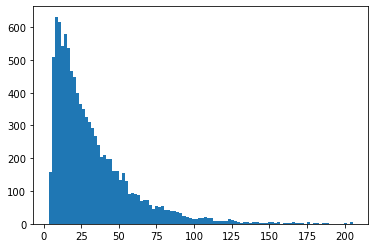

In [80]:
# Traditional method
import numpy as np
import matplotlib.pyplot as plt

def ReadPMT(geo):
    f = open(r'../PMT_' + geo + '.txt')
    line = f.readline()
    data_list = []
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    PMT_pos = PMT_pos
    return PMT_pos

PMT_pos = ReadPMT('1t')
vertex = [0,0,0.3]
dist = np.sqrt(np.sum((PMT_pos - vertex)**2,axis=1))
c, n = 3e8, 1.5 # light speed and refraction
N = 10000
fired =  np.random.randint(0,30,N)
flight_time = dist[fired]/(c/n)*1e9
time_profile = sampling(N, 26)

receive_time = flight_time + time_profile
plt.hist(receive_time, bins=100)
plt.show()

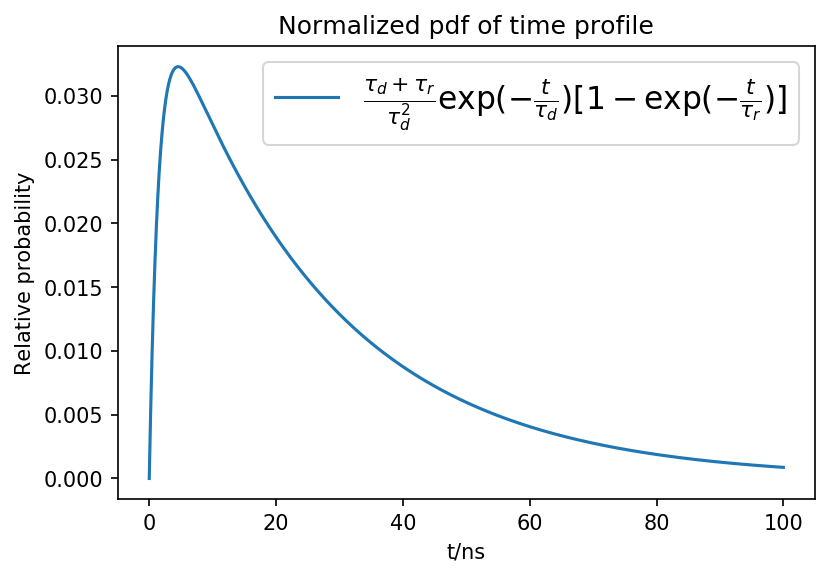

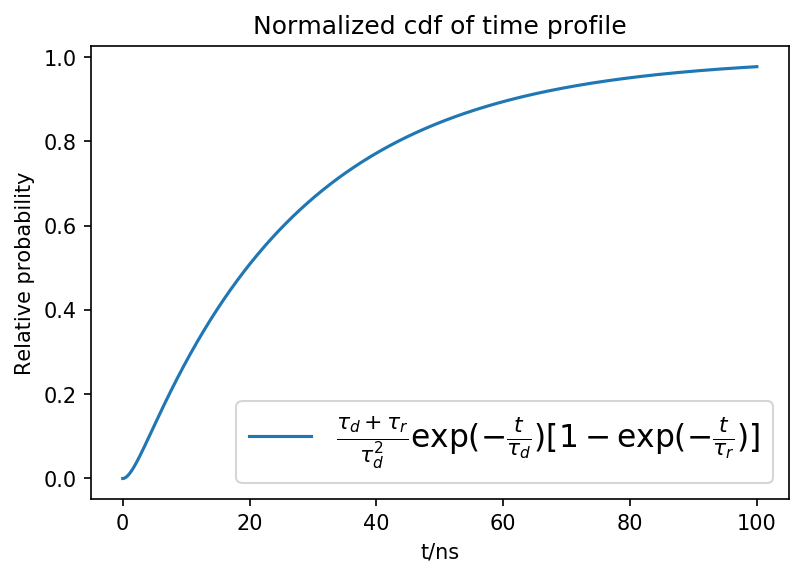

In [81]:
t = np.arange(0,100,0.01)
a = (26+1.6)/26**2*np.exp(-t/26)*(1-np.exp(-t/1.6))
plt.figure(num=1, dpi=150)
plt.plot(t,a)
plt.xlabel('t/ns')
plt.ylabel('Relative probability')
plt.title('Normalized pdf of time profile')
plt.legend([r'$\frac{\tau_d+\tau_r}{\tau_d^2}\exp(-\frac{t}{\tau_d})[1-\exp({-\frac{t}{\tau_r}})]$'], \
          fontsize = 15)
plt.show()

t = np.arange(0,100,0.01)
a = (26+1.6)/26**2*np.exp(-t/26)*(1-np.exp(-t/1.6))
plt.figure(num=2, dpi=150)
plt.plot(t,np.cumsum(a)/100)
plt.xlabel('t/ns')
plt.ylabel('Relative probability')
plt.title('Normalized cdf of time profile')
plt.legend([r'$\frac{\tau_d+\tau_r}{\tau_d^2}\exp(-\frac{t}{\tau_d})[1-\exp({-\frac{t}{\tau_r}})]$'], \
          fontsize = 15)
plt.show()

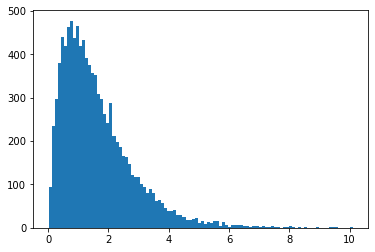

In [82]:
# sampling
def sampling(N, tau_d):
    step = 0.01
    tau_r = 1.6
    t = np.arange(0,200,step)
    a = (tau_d+tau_r)/tau_d**2*np.exp(-t/tau_d)*(1-np.exp(-t/tau_r))
    ta = np.random.rand(N)
    ai = np.interp(ta, np.cumsum(a)*step,t,left=None,right=None,period=None)
    return ai

a = sampling(10000, 1)
plt.hist(a,bins=100)
plt.show()

## Traditional ML:
$$ t_{i,f} = \vec{x}_i - \vec{x}_0$$ 

| Parameter | Mean | 
| - | -: | 
| $t_{i,f}$ | flight time of photons to $i$-th PMT|  
| $\vec{x}_i$ | $i$-th PMT position |  
| $\vec{x}_0$ | vertex |  

$$ t_{i'} = t_{i',r}  - t_{\delta(i,i'),f} $$

| Parameter | Mean | 
| - | -: | 
| $ t_{i'} $ | correct time|  
| $ t_{i',r} $ | $i'$-th photon received time |  
| $\delta(i,i')$ | delta funtion to judge $i'$-th photon received by $i$-th PMT |  

$$ \mathcal{L} = \sum \log p(t_i') $$

| Parameter | Mean | 
| - | -: | 
| $\mathcal{L}$ | Likelihood |  
| $p(t)$ |Time profile |


In [11]:
# Simulate
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import special

def ReadPMT(geo):
    f = open(r'../PMT_' + geo + '.txt')
    line = f.readline()
    data_list = []
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    PMT_pos = PMT_pos
    return PMT_pos

def Simulate(vertex, N, tau_d):
    PMT_pos = ReadPMT('1t')
    dist = np.sqrt(np.sum((PMT_pos - vertex)**2,axis=1))
    c, n = 3e8, 1.5 # light speed and refraction
    fired =  np.random.randint(0,30,N)
    flight_time = dist[fired]/(c/n)*1e9
    time_profile = sampling(N, tau_d)
    receive_time = flight_time + time_profile
    return receive_time, fired

In [75]:
def recon(vertex, *args):
    time, PMT_pos, fired, tau_d = args
    y = time - vertex[0]
    dist = np.sqrt(np.sum((PMT_pos[fired] - vertex[1:4])**2, axis=1))
    flight_time = dist/(3e8/1.5)*1e9
    L = - np.nansum(TimeProfile(y, flight_time, tau_d))
    return L
    
def TimeProfile(y,T_i, tau_d):
    time_correct = y - T_i
    time_correct[time_correct<=1e-3] = 1e-3
    p_time = TimeUncertainty(time_correct, tau_d)
    return p_time

def TimeUncertainty(tc, tau_d):
    tau_r = 1.6
    a = (tau_d + tau_r)/tau_d**2*np.exp(-tc/tau_d)*(1-np.exp(-tc/tau_r))
    p_time  = np.log(a)
    return p_time

def con_sph():
    cons = ({'type': 'ineq', 'fun': lambda x: 0.65**2 - (x[1]**2 + x[2]**2 + x[3]**2)})
    return cons

processing 100-th event
processing 200-th event
processing 300-th event
processing 400-th event
processing 500-th event
processing 600-th event


/opt/gentoo/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


processing 700-th event
processing 800-th event
processing 900-th event
processing 1000-th event


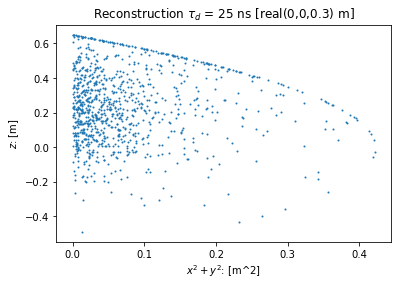

In [77]:
tau_d = 25
event = 1e3
record = []
cons_sph = con_sph()
for i in np.arange(event):

    time, fired = Simulate(np.array([0,0,0.3]),100, tau_d)
    PMT_pos = ReadPMT('1t')
    x0 = np.array((0,0,0,0))
    result = minimize(recon, x0, method='SLSQP', constraints = cons_sph, args = (time, PMT_pos, fired, tau_d))
    record.append(result.x)
    if((i+1)%100==0):
        print('processing %d-th event' % (i+1))

index = (np.array(record)[:,1]**2 + np.array(record)[:,2]**2 + np.array(record)[:,3]**2) < 1
plt.scatter(np.array(record)[index,1]**2 + np.array(record)[index,2]**2, np.array(record)[index,3], s=1)
plt.axis('tight')
plt.title(r'Reconstruction $\tau_d$ = %d ns [real(0,0,0.3) m]' % tau_d)
plt.xlabel(r'$x^2+y^2$: [m^2]')
plt.ylabel(r'$z$: [m]')
plt.show()

processing 100-th event


/opt/gentoo/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


processing 200-th event
processing 300-th event
processing 400-th event
processing 500-th event
processing 600-th event
processing 700-th event
processing 800-th event
processing 900-th event
processing 1000-th event


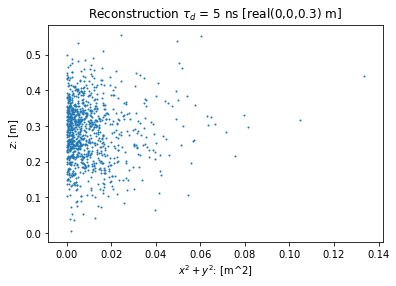

In [78]:
tau_d = 5
event = 1e3
record = []
cons_sph = con_sph()
for i in np.arange(event):

    time, fired = Simulate(np.array([0,0,0.3]),100, tau_d)
    PMT_pos = ReadPMT('1t')
    x0 = np.array((0,0,0,0))
    result = minimize(recon, x0, method='SLSQP', constraints = cons_sph, args = (time, PMT_pos, fired, tau_d))
    record.append(result.x)
    if((i+1)%100==0):
        print('processing %d-th event' % (i+1))

index = (np.array(record)[:,1]**2 + np.array(record)[:,2]**2 + np.array(record)[:,3]**2) < 1
plt.scatter(np.array(record)[index,1]**2 + np.array(record)[index,2]**2, np.array(record)[index,3], s=1)
plt.axis('tight')
plt.title(r'Reconstruction $\tau_d$ = %d ns [real(0,0,0.3) m]' % tau_d)
plt.xlabel(r'$x^2+y^2$: [m^2]')
plt.ylabel(r'$z$: [m]')
plt.show()

# 1st photon distribution
Time profile: $p(t)$  
Assuming $N$ photons on total, the first photon received at time $t$ indicate that:
$$ p'(t) = C_N^1 p(t) [\int_t^\infty p(x) \mathrm{d}x]^{N-1}$$

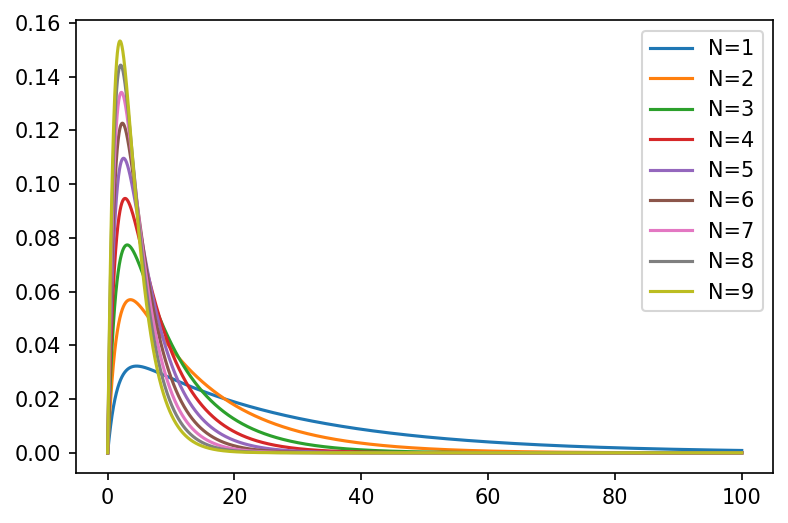

In [121]:
# p(t)
tau_d = 26
tau_r = 1.6
t = np.arange(0,100,0.01)
tp = (tau_d+tau_r)/tau_d**2*np.exp(-t/tau_d)*(1-np.exp(-t/tau_r))
legend_str = []
plt.figure(num=1, dpi=150)
for i in np.arange(1,10):
    p = np.zeros_like(t)
    for k_index,k in enumerate(t):
        p[k_index] = i * tp[k_index] * (np.sum(tp[k_index:])/100)**(i-1)
    plt.plot(t,p)
    legend_str.append('N=%d' % i)

plt.legend(legend_str)
plt.show()

[ 3.16169587e-02 -1.42694253e+01  3.50434521e+01]


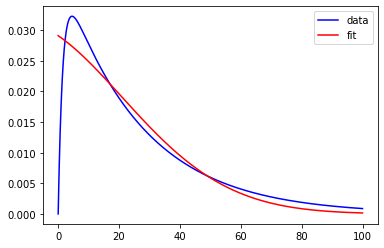

[ 0.04646241  3.13568619 12.75505937]


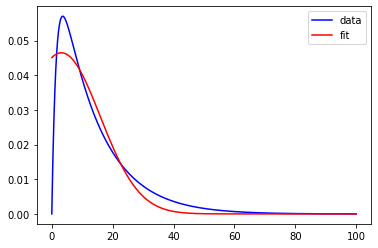

[0.06354267 4.07574424 7.63092897]


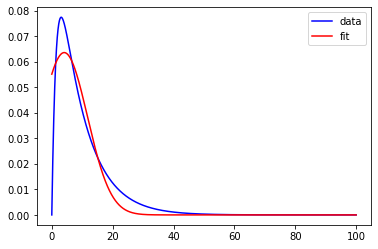

[0.07949185 3.86810005 5.50179384]


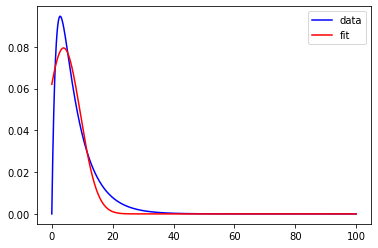

[0.09386622 3.55418424 4.36206437]


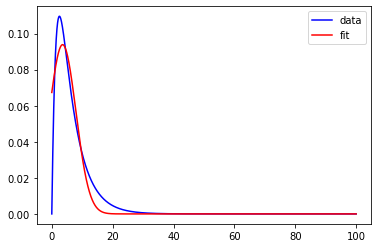

[0.10670646 3.27068596 3.65509721]


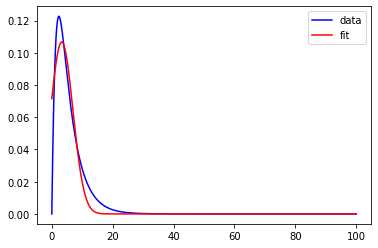

[0.11815842 3.03166436 3.17300394]


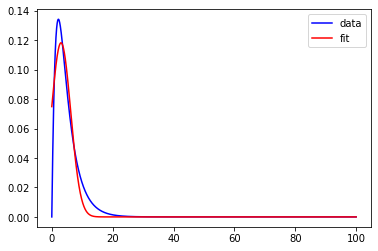

[0.12837853 2.83142997 2.8220255 ]


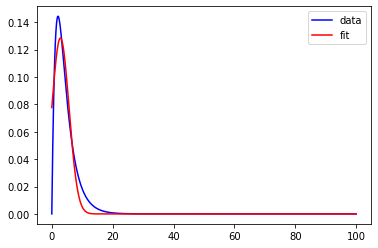

[0.13750673 2.66229878 2.55416178]


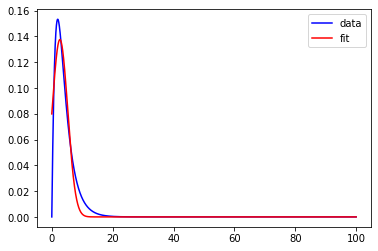

In [127]:
from scipy.optimize import curve_fit

def gaussian(x,*param):
    return param[0]*np.exp(-np.power(x - param[1], 2.) / (2 * np.power(param[2], 2.)))

tau_d = 26
tau_r = 1.6
t = np.arange(0,100,0.01)
tp = (tau_d+tau_r)/tau_d**2*np.exp(-t/tau_d)*(1-np.exp(-t/tau_r))
legend_str = []
for i in np.arange(1,10):
    p = np.zeros_like(t)
    for k_index,k in enumerate(t):
        p[k_index] = i * tp[k_index] * (np.sum(tp[k_index:])/100)**(i-1)
        
    popt,pcov = curve_fit(gaussian,t,p,p0=[1,1,1])
    print(popt)
    plt.plot(t,p,'b',label='data')
    plt.plot(t,gaussian(t,*popt),'r',label='fit')
    plt.legend()
    plt.show()